# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
import pandas as pd
import sqlalchemy as db

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from sklearn.base import TransformerMixin, BaseEstimator

import pickle

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Tu run tensorflow on CPU


In [6]:
# load data from database
engine = db.create_engine('sqlite:///messages_and_categories.db')
df = pd.read_sql_table('messages_and_categories', con=engine)
X = df['message']
column_names = df.columns
Y = df[column_names[4:]]


In [9]:
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
Y.head()


,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

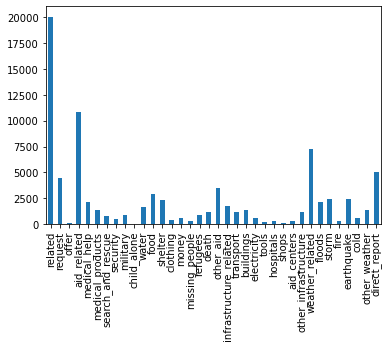

In [11]:
Y.sum().plot(kind='bar')

<AxesSubplot:>

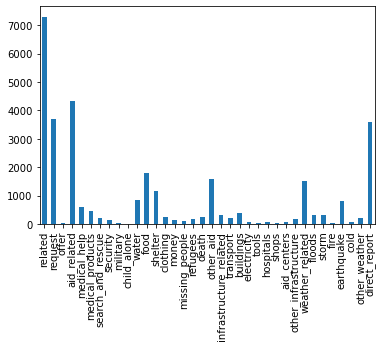

In [21]:
df[df['genre'] == 'direct'][column_names[4:]].sum().plot(kind='bar')

<AxesSubplot:>

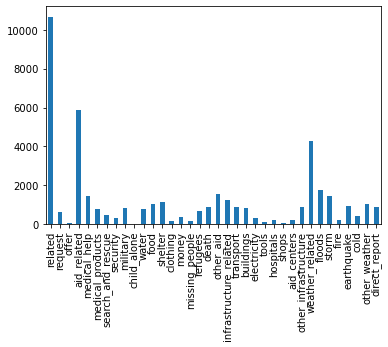

In [22]:
df[df['genre'] == 'news'][column_names[4:]].sum().plot(kind='bar')

<AxesSubplot:>

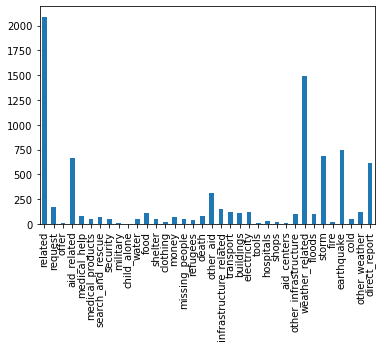

In [23]:
df[df['genre'] == 'social'][column_names[4:]].sum().plot(kind='bar')

In [54]:
full_text = ''
for i in range(df.shape[0]):
    full_text = full_text + df['message'].iloc[i] 
print(len(full_text))
# df['message'].iloc[0]
from collections import Counter

# split() returns list of all the words in the string
# split_it = full_text.split()
split_it = tokenize(full_text)

  
# Pass the split_it list to instance of Counter class.
Counter = Counter(split_it)
  
# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counter.most_common(20)
print(most_occur)

3790297
[('water', 3010), ('people', 2957), ('food', 2849), ('help', 2567), ('need', 2477), ('please', 1915), ('earthquake', 1834), ('u', 1702), ('area', 1655), ('like', 1526), ('would', 1482), ('said', 1350), ('000', 1251), ('country', 1242), ('http', 1232), ('know', 1110), ('also', 1109), ('government', 1055), ('one', 1013), ('rain', 1008)]


In [58]:
values = [most_occur[i][1] for i in range(len(most_occur))]
names = [most_occur[i][0] for i in range(len(most_occur))]

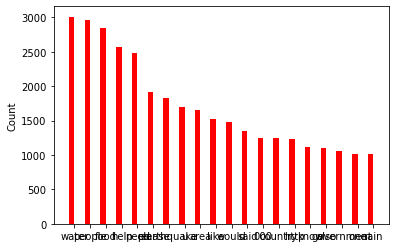

In [60]:
import matplotlib.pyplot as plt

values = [most_occur[i][1] for i in range(len(most_occur))]
ind = np.arange(len(most_occur))  # the x locations for the groups
width = 0.35       # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind, values, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Count')
ax.set_xticks(ind+width/2.)
ax.set_xticklabels(names);

### 2. Write a tokenization function to process your text data

In [3]:
def tokenize(text):
    '''
    INPUT
    text - the input text
    
    OUTPUT
    tokens - the tokenized text
    
    This function cleans the tokenize the input text
    '''
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

In [4]:
# test the tokenize function
corpus = ["The first time you see The Second Renaissance it may look boring."]
tokens = tokenize(corpus[0])
tokens

['first', 'time', 'see', 'second', 'renaissance', 'may', 'look', 'boring']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [5]:
# build a machine learning pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(KNeighborsClassifier(n_jobs=-1)))
])

# pipeline = Pipeline([
#     ('vect', CountVectorizer(tokenizer=tokenize)),
#     ('tfidf', TfidfTransformer()),
#     ('clf', MultiOutputClassifier(RandomForestClassifier(n_jobs=-1)))
# ])



### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [6]:
def display_results(y_test, y_pred):
    """
    INPUT 
    y_test - the actual label
    y_pred - the predicted label
    
    This function computes the accuracy based on 
    y_test and y_pred and prints the accuracy for each label
    """
    labels = np.unique(y_pred)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Accuracy:", accuracy)

In [7]:
# split the dataset into test and training 
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [8]:
# fit the pipeline 
pipeline.fit(X_train, y_train)

# predict on test data
y_pred = pipeline.predict(X_test)

# display results
display_results(y_test, y_pred)

Labels: [0 1]
Accuracy: related                   0.792819
request                   0.858365
offer                     0.995722
aid_related               0.651337
medical_help              0.921467
medical_products          0.950802
search_and_rescue         0.974179
security                  0.983193
military                  0.968831
child_alone               1.000000
water                     0.939190
food                      0.897326
shelter                   0.917953
clothing                  0.985638
money                     0.974332
missing_people            0.989458
refugees                  0.966845
death                     0.955080
other_aid                 0.866921
infrastructure_related    0.934912
transport                 0.955386
buildings                 0.949580
electricity               0.982582
tools                     0.993277
hospitals                 0.990069
shops                     0.995875
aid_centers               0.988694
other_infrastructure      0.953

In [8]:
pickle.dump(pipeline, open('KNeighbors_model', 'wb'))

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [22]:
for column_number, column_name in enumerate(y_test.columns):
    print(f"Clasification Report for the feature {column_name} is:\n")
    print(classification_report(y_test[column_name], y_pred[:,column_number], zero_division=0))


Clasification Report for the feature related is:

              precision    recall  f1-score   support

           0       0.72      0.12      0.20      1553
           1       0.78      0.99      0.87      4992

    accuracy                           0.78      6545
   macro avg       0.75      0.55      0.54      6545
weighted avg       0.77      0.78      0.71      6545

Clasification Report for the feature request is:

              precision    recall  f1-score   support

           0       0.85      1.00      0.91      5470
           1       0.78      0.08      0.15      1075

    accuracy                           0.85      6545
   macro avg       0.81      0.54      0.53      6545
weighted avg       0.83      0.85      0.79      6545

Clasification Report for the feature offer is:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6515
           1       0.00      0.00      0.00        30

    accuracy                      

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6520
           1       0.00      0.00      0.00        25

    accuracy                           1.00      6545
   macro avg       0.50      0.50      0.50      6545
weighted avg       0.99      1.00      0.99      6545

Clasification Report for the feature aid_centers is:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6468
           1       0.00      0.00      0.00        77

    accuracy                           0.99      6545
   macro avg       0.49      0.50      0.50      6545
weighted avg       0.98      0.99      0.98      6545

Clasification Report for the feature other_infrastructure is:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6251
           1       0.00      0.00      0.00       294

    accuracy                           0.96      6545
   macro av

In [12]:
classification_report(y_test[column_name], y_pred[:,column_number], zero_division=0)

'              precision    recall  f1-score   support\n\n           0       0.82      0.99      0.90      5317\n           1       0.70      0.06      0.10      1228\n\n    accuracy                           0.82      6545\n   macro avg       0.76      0.53      0.50      6545\nweighted avg       0.80      0.82      0.75      6545\n'

In [43]:
classification_report_base_model = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

In [44]:
classification_report_base_model.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', 'micro avg', 'macro avg', 'weighted avg', 'samples avg'])

In [45]:
classification_report_base_model['weighted avg']

{'precision': 0.6512867497340137,
 'recall': 0.2645543784624356,
 'f1-score': 0.2589967196093154,
 'support': 20578}

In [46]:
classification_report_base_model['samples avg']

{'precision': 0.746823092873513,
 'recall': 0.33933809793408265,
 'f1-score': 0.408443209854941,
 'support': 20578}

### 6. Improve your model
Use grid search to find better parameters. 

In [55]:
# select some hyperparameters to see which set creates the best response

parameters = {'vect__binary': (True, False),
         'vect__max_df': (0.5, 0.75, 1.0),
         'tfidf__smooth_idf': (True, False),
         'tfidf__use_idf': (True, False),
         'clf__estimator__leaf_size': [10, 30, 60],
         'clf__estimator__n_neighbors': [5, 10, 20],
             }
f1_scorer = make_scorer(fbeta_score, beta=1, average='samples', zero_division=0)
cv = GridSearchCV(pipeline, scoring=f1_scorer, param_grid=parameters, cv=2, verbose=3)
cv.fit(X_train, y_train)
y_pred_cv = cv.predict(X_test)

Fitting 2 folds for each of 216 candidates, totalling 432 fits
[CV 1/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=5, tfidf__smooth_idf=True, tfidf__use_idf=True, vect__binary=True, vect__max_df=0.5;, score=0.428 total time= 2.2min
[CV 2/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=5, tfidf__smooth_idf=True, tfidf__use_idf=True, vect__binary=True, vect__max_df=0.5;, score=0.443 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=5, tfidf__smooth_idf=True, tfidf__use_idf=True, vect__binary=True, vect__max_df=0.75;, score=0.428 total time= 2.2min
[CV 2/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=5, tfidf__smooth_idf=True, tfidf__use_idf=True, vect__binary=True, vect__max_df=0.75;, score=0.443 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=5, tfidf__smooth_idf=True, tfidf__use_idf=True, vect__binary=True, vect__max_df=1.0;, score=0.428 total time= 2.

[CV 2/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=5, tfidf__smooth_idf=False, tfidf__use_idf=False, vect__binary=False, vect__max_df=0.5;, score=0.461 total time= 2.2min
[CV 1/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=5, tfidf__smooth_idf=False, tfidf__use_idf=False, vect__binary=False, vect__max_df=0.75;, score=0.451 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=5, tfidf__smooth_idf=False, tfidf__use_idf=False, vect__binary=False, vect__max_df=0.75;, score=0.461 total time= 2.2min
[CV 1/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=5, tfidf__smooth_idf=False, tfidf__use_idf=False, vect__binary=False, vect__max_df=1.0;, score=0.451 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=5, tfidf__smooth_idf=False, tfidf__use_idf=False, vect__binary=False, vect__max_df=1.0;, score=0.461 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=10, 

[CV 1/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=10, tfidf__smooth_idf=False, tfidf__use_idf=False, vect__binary=True, vect__max_df=0.75;, score=0.450 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=10, tfidf__smooth_idf=False, tfidf__use_idf=False, vect__binary=True, vect__max_df=0.75;, score=0.458 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=10, tfidf__smooth_idf=False, tfidf__use_idf=False, vect__binary=True, vect__max_df=1.0;, score=0.450 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=10, tfidf__smooth_idf=False, tfidf__use_idf=False, vect__binary=True, vect__max_df=1.0;, score=0.458 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=10, tfidf__smooth_idf=False, tfidf__use_idf=False, vect__binary=False, vect__max_df=0.5;, score=0.453 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=10,

[CV 2/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=20, tfidf__smooth_idf=False, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.75;, score=0.459 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=20, tfidf__smooth_idf=False, tfidf__use_idf=True, vect__binary=False, vect__max_df=1.0;, score=0.456 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=20, tfidf__smooth_idf=False, tfidf__use_idf=True, vect__binary=False, vect__max_df=1.0;, score=0.459 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=20, tfidf__smooth_idf=False, tfidf__use_idf=False, vect__binary=True, vect__max_df=0.5;, score=0.474 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=10, clf__estimator__n_neighbors=20, tfidf__smooth_idf=False, tfidf__use_idf=False, vect__binary=True, vect__max_df=0.5;, score=0.479 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=10, c

[CV 2/2] END clf__estimator__leaf_size=30, clf__estimator__n_neighbors=5, tfidf__smooth_idf=False, tfidf__use_idf=True, vect__binary=True, vect__max_df=1.0;, score=0.444 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=30, clf__estimator__n_neighbors=5, tfidf__smooth_idf=False, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.5;, score=0.430 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=30, clf__estimator__n_neighbors=5, tfidf__smooth_idf=False, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.5;, score=0.442 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=30, clf__estimator__n_neighbors=5, tfidf__smooth_idf=False, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.75;, score=0.430 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=30, clf__estimator__n_neighbors=5, tfidf__smooth_idf=False, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.75;, score=0.442 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=30, clf__e

[CV 2/2] END clf__estimator__leaf_size=30, clf__estimator__n_neighbors=10, tfidf__smooth_idf=False, tfidf__use_idf=True, vect__binary=True, vect__max_df=0.5;, score=0.436 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=30, clf__estimator__n_neighbors=10, tfidf__smooth_idf=False, tfidf__use_idf=True, vect__binary=True, vect__max_df=0.75;, score=0.426 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=30, clf__estimator__n_neighbors=10, tfidf__smooth_idf=False, tfidf__use_idf=True, vect__binary=True, vect__max_df=0.75;, score=0.436 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=30, clf__estimator__n_neighbors=10, tfidf__smooth_idf=False, tfidf__use_idf=True, vect__binary=True, vect__max_df=1.0;, score=0.426 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=30, clf__estimator__n_neighbors=10, tfidf__smooth_idf=False, tfidf__use_idf=True, vect__binary=True, vect__max_df=1.0;, score=0.436 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=30, clf__

[CV 1/2] END clf__estimator__leaf_size=30, clf__estimator__n_neighbors=20, tfidf__smooth_idf=True, tfidf__use_idf=False, vect__binary=False, vect__max_df=0.75;, score=0.473 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=30, clf__estimator__n_neighbors=20, tfidf__smooth_idf=True, tfidf__use_idf=False, vect__binary=False, vect__max_df=0.75;, score=0.480 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=30, clf__estimator__n_neighbors=20, tfidf__smooth_idf=True, tfidf__use_idf=False, vect__binary=False, vect__max_df=1.0;, score=0.473 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=30, clf__estimator__n_neighbors=20, tfidf__smooth_idf=True, tfidf__use_idf=False, vect__binary=False, vect__max_df=1.0;, score=0.480 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=30, clf__estimator__n_neighbors=20, tfidf__smooth_idf=False, tfidf__use_idf=True, vect__binary=True, vect__max_df=0.5;, score=0.452 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=30, c

[CV 1/2] END clf__estimator__leaf_size=60, clf__estimator__n_neighbors=5, tfidf__smooth_idf=True, tfidf__use_idf=False, vect__binary=True, vect__max_df=1.0;, score=0.448 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=60, clf__estimator__n_neighbors=5, tfidf__smooth_idf=True, tfidf__use_idf=False, vect__binary=True, vect__max_df=1.0;, score=0.461 total time= 2.2min
[CV 1/2] END clf__estimator__leaf_size=60, clf__estimator__n_neighbors=5, tfidf__smooth_idf=True, tfidf__use_idf=False, vect__binary=False, vect__max_df=0.5;, score=0.451 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=60, clf__estimator__n_neighbors=5, tfidf__smooth_idf=True, tfidf__use_idf=False, vect__binary=False, vect__max_df=0.5;, score=0.461 total time= 2.2min
[CV 1/2] END clf__estimator__leaf_size=60, clf__estimator__n_neighbors=5, tfidf__smooth_idf=True, tfidf__use_idf=False, vect__binary=False, vect__max_df=0.75;, score=0.451 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=60, clf__est

[CV 1/2] END clf__estimator__leaf_size=60, clf__estimator__n_neighbors=10, tfidf__smooth_idf=True, tfidf__use_idf=False, vect__binary=True, vect__max_df=0.5;, score=0.450 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=60, clf__estimator__n_neighbors=10, tfidf__smooth_idf=True, tfidf__use_idf=False, vect__binary=True, vect__max_df=0.5;, score=0.458 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=60, clf__estimator__n_neighbors=10, tfidf__smooth_idf=True, tfidf__use_idf=False, vect__binary=True, vect__max_df=0.75;, score=0.450 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=60, clf__estimator__n_neighbors=10, tfidf__smooth_idf=True, tfidf__use_idf=False, vect__binary=True, vect__max_df=0.75;, score=0.458 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=60, clf__estimator__n_neighbors=10, tfidf__smooth_idf=True, tfidf__use_idf=False, vect__binary=True, vect__max_df=1.0;, score=0.450 total time= 2.3min
[CV 2/2] END clf__estimator__leaf_size=60, clf__

[CV 2/2] END clf__estimator__leaf_size=60, clf__estimator__n_neighbors=20, tfidf__smooth_idf=True, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.5;, score=0.459 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=60, clf__estimator__n_neighbors=20, tfidf__smooth_idf=True, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.75;, score=0.457 total time= 2.2min
[CV 2/2] END clf__estimator__leaf_size=60, clf__estimator__n_neighbors=20, tfidf__smooth_idf=True, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.75;, score=0.459 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=60, clf__estimator__n_neighbors=20, tfidf__smooth_idf=True, tfidf__use_idf=True, vect__binary=False, vect__max_df=1.0;, score=0.457 total time= 2.2min
[CV 2/2] END clf__estimator__leaf_size=60, clf__estimator__n_neighbors=20, tfidf__smooth_idf=True, tfidf__use_idf=True, vect__binary=False, vect__max_df=1.0;, score=0.459 total time= 2.3min
[CV 1/2] END clf__estimator__leaf_size=60, clf__

In [56]:
display_results(y_test, y_pred_cv)

Labels: [0 1]
Accuracy: related                   0.805653
request                   0.890756
offer                     0.995416
aid_related               0.716425
medical_help              0.920397
medical_products          0.950191
search_and_rescue         0.973262
security                  0.983652
military                  0.969442
child_alone               1.000000
water                     0.952177
food                      0.924064
shelter                   0.918564
clothing                  0.983499
money                     0.975401
missing_people            0.988083
refugees                  0.964095
death                     0.958747
other_aid                 0.870588
infrastructure_related    0.933843
transport                 0.954163
buildings                 0.951261
electricity               0.980443
tools                     0.993125
hospitals                 0.987777
shops                     0.996180
aid_centers               0.988235
other_infrastructure      0.955

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [57]:
for column_number, column_name in enumerate(y_test.columns):
    print(f"Clasification Report for the feature {column_name} is:\n")
    print(classification_report(y_test[column_name], y_pred_cv[:,column_number]))
y_test.shape

Clasification Report for the feature related is:

              precision    recall  f1-score   support

           0       0.68      0.35      0.46      1553
           1       0.82      0.95      0.88      4992

    accuracy                           0.81      6545
   macro avg       0.75      0.65      0.67      6545
weighted avg       0.79      0.81      0.78      6545

Clasification Report for the feature request is:

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5470
           1       0.75      0.51      0.60      1075

    accuracy                           0.89      6545
   macro avg       0.83      0.74      0.77      6545
weighted avg       0.88      0.89      0.88      6545

Clasification Report for the feature offer is:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6515
           1       0.00      0.00      0.00        30

    accuracy                      

/nethome/m.chamanbaz/anaconda3/envs/tf_test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nethome/m.chamanbaz/anaconda3/envs/tf_test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nethome/m.chamanbaz/anaconda3/envs/tf_test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6465
           1       0.00      0.00      0.00        80

    accuracy                           0.99      6545
   macro avg       0.49      0.50      0.50      6545
weighted avg       0.98      0.99      0.98      6545

Clasification Report for the feature shops is:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6520
           1       0.00      0.00      0.00        25

    accuracy                           1.00      6545
   macro avg       0.50      0.50      0.50      6545
weighted avg       0.99      1.00      0.99      6545

Clasification Report for the feature aid_centers is:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6468
           1       0.00      0.00      0.00        77

    accuracy                           0.99      6545
   macro avg       0.49   

/nethome/m.chamanbaz/anaconda3/envs/tf_test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nethome/m.chamanbaz/anaconda3/envs/tf_test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(6545, 36)

In [61]:
classification_report_tuned_model = classification_report(y_test, y_pred_cv, zero_division=0, output_dict=True)

In [62]:
classification_report_tuned_model['weighted avg']

{'precision': 0.7165509293262959,
 'recall': 0.43910972883662164,
 'f1-score': 0.48662324021859166,
 'support': 20578}

In [63]:
classification_report_tuned_model['samples avg']

{'precision': 0.6743389477002922,
 'recall': 0.4309946983398286,
 'f1-score': 0.47000218882373784,
 'support': 20578}

Export the tuned model as a pickle file.

In [64]:
pickle.dump(cv, open('tuned_KNeighbors', 'wb'))

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [8]:
class modify_input(BaseEstimator, TransformerMixin):
    """ This class is defined to modify the input to the 
    neural network classifier. """

    def transform(self, X):
        
        return X.toarray()

    def fit(self, X, y=None, **fit_params):
        return self


In [9]:
def get_model(number_of_layers, depth_of_layers):
    """
    INPUT
    number_of_layers - the number of hidden layers in the neural network
    depth_of_layers - depth of each hidden layer
    
    OUTPUT
    A Keras model designed for multioutput classification
    
    """
    n_outputs = y_train.shape[1]
    model = keras.models.Sequential()
    for _ in range(number_of_layers):
        model.add(keras.layers.Dense(depth_of_layers, activation='relu'))
        model.add(keras.layers.Dropout(0.5))
    
    model.add(keras.layers.Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model

Define the pipeline which uses a neural network classifier. 
Please note that the classifier is wrapped in KerasClassifier which is imported from scikeras library.
sklearn KerasClassifier does not handle multioutput models

In [10]:
pipeline_NN = Pipeline([
   ('vect', CountVectorizer(tokenizer=tokenize)),
   ('tfidf', TfidfTransformer()),
   ('debug', modify_input()),
   ('clf', KerasClassifier(model=get_model, 
                        number_of_layers=2, 
                        depth_of_layers=20, 
                        epochs=10, 
                        batch_size=512, 
                        verbose=0, 
                        loss='binary_crossentropy', 
                        optimizer='adam',
                        metrics=['accuracy']))])

Define the parameters to be tuned including the depth and the number of hidden layers.

In [11]:
parameters = {'vect__binary': (True, False),
         'vect__max_df': (0.5, 1.0),
         'tfidf__use_idf': (True, False),
         'clf__epochs':[50, 100],
         'clf__number_of_layers':[2,5,10],
         'clf__depth_of_layers':[10,20,50]
             }

In [12]:
f1_scorer = make_scorer(fbeta_score, beta=1, average='samples', zero_division=0)
cv_NN = GridSearchCV(pipeline_NN, scoring=f1_scorer, param_grid=parameters, cv=2, verbose=3)
cv_NN.fit(X_train, y_train)
#predict on test data
y_pred_NN = cv_NN.predict(X_test)

Fitting 2 folds for each of 144 candidates, totalling 288 fits


2022-01-25 15:22:38.825378: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-25 15:22:38.825424: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: rtcma-rhel-d1.rtcma.acfr.usyd.edu.au
2022-01-25 15:22:38.825434: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: rtcma-rhel-d1.rtcma.acfr.usyd.edu.au
2022-01-25 15:22:38.825590: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2022-01-25 15:22:38.825642: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2022-01-25 15:22:38.825656: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2022-01-25 15:22:38.825967: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Li

[CV 1/2] END clf__depth_of_layers=10, clf__epochs=50, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=True, vect__max_df=0.5;, score=0.418 total time=  31.4s
[CV 2/2] END clf__depth_of_layers=10, clf__epochs=50, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=True, vect__max_df=0.5;, score=0.415 total time=  30.3s
[CV 1/2] END clf__depth_of_layers=10, clf__epochs=50, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=True, vect__max_df=1.0;, score=0.411 total time=  27.5s
[CV 2/2] END clf__depth_of_layers=10, clf__epochs=50, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=True, vect__max_df=1.0;, score=0.418 total time=  33.1s
[CV 1/2] END clf__depth_of_layers=10, clf__epochs=50, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.5;, score=0.416 total time=  26.1s
[CV 2/2] END clf__depth_of_layers=10, clf__epochs=50, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.5;, score=0.406 tot

[CV 2/2] END clf__depth_of_layers=10, clf__epochs=100, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=True, vect__max_df=0.5;, score=0.432 total time=  43.2s
[CV 1/2] END clf__depth_of_layers=10, clf__epochs=100, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=True, vect__max_df=1.0;, score=0.430 total time=  42.6s
[CV 2/2] END clf__depth_of_layers=10, clf__epochs=100, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=True, vect__max_df=1.0;, score=0.433 total time=  42.9s
[CV 1/2] END clf__depth_of_layers=10, clf__epochs=100, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.5;, score=0.431 total time=  43.3s
[CV 2/2] END clf__depth_of_layers=10, clf__epochs=100, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.5;, score=0.434 total time=  42.4s
[CV 1/2] END clf__depth_of_layers=10, clf__epochs=100, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=1.0;, score=0.

[CV 2/2] END clf__depth_of_layers=20, clf__epochs=50, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=True, vect__max_df=0.5;, score=0.445 total time=  27.7s
[CV 1/2] END clf__depth_of_layers=20, clf__epochs=50, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=True, vect__max_df=1.0;, score=0.454 total time=  27.6s
[CV 2/2] END clf__depth_of_layers=20, clf__epochs=50, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=True, vect__max_df=1.0;, score=0.435 total time=  27.7s
[CV 1/2] END clf__depth_of_layers=20, clf__epochs=50, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.5;, score=0.431 total time=  27.6s
[CV 2/2] END clf__depth_of_layers=20, clf__epochs=50, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.5;, score=0.448 total time=  27.8s
[CV 1/2] END clf__depth_of_layers=20, clf__epochs=50, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=1.0;, score=0.437 to

[CV 1/2] END clf__depth_of_layers=20, clf__epochs=100, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=True, vect__max_df=1.0;, score=0.450 total time=  44.0s
[CV 2/2] END clf__depth_of_layers=20, clf__epochs=100, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=True, vect__max_df=1.0;, score=0.462 total time=  45.5s
[CV 1/2] END clf__depth_of_layers=20, clf__epochs=100, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.5;, score=0.450 total time=  44.7s
[CV 2/2] END clf__depth_of_layers=20, clf__epochs=100, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.5;, score=0.451 total time=  44.4s
[CV 1/2] END clf__depth_of_layers=20, clf__epochs=100, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=1.0;, score=0.440 total time=  44.4s
[CV 2/2] END clf__depth_of_layers=20, clf__epochs=100, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=1.0;, score=0

[CV 1/2] END clf__depth_of_layers=50, clf__epochs=50, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=True, vect__max_df=1.0;, score=0.451 total time=  35.3s
[CV 2/2] END clf__depth_of_layers=50, clf__epochs=50, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=True, vect__max_df=1.0;, score=0.458 total time=  35.8s
[CV 1/2] END clf__depth_of_layers=50, clf__epochs=50, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.5;, score=0.454 total time=  35.7s
[CV 2/2] END clf__depth_of_layers=50, clf__epochs=50, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.5;, score=0.454 total time=  35.4s
[CV 1/2] END clf__depth_of_layers=50, clf__epochs=50, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=1.0;, score=0.450 total time=  35.2s
[CV 2/2] END clf__depth_of_layers=50, clf__epochs=50, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=1.0;, score=0.453 t

[CV 2/2] END clf__depth_of_layers=50, clf__epochs=100, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=True, vect__max_df=1.0;, score=0.445 total time= 1.0min
[CV 1/2] END clf__depth_of_layers=50, clf__epochs=100, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.5;, score=0.445 total time=  59.4s
[CV 2/2] END clf__depth_of_layers=50, clf__epochs=100, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=0.5;, score=0.449 total time= 1.0min
[CV 1/2] END clf__depth_of_layers=50, clf__epochs=100, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=1.0;, score=0.447 total time=  59.5s
[CV 2/2] END clf__depth_of_layers=50, clf__epochs=100, clf__number_of_layers=2, tfidf__use_idf=True, vect__binary=False, vect__max_df=1.0;, score=0.442 total time= 1.0min
[CV 1/2] END clf__depth_of_layers=50, clf__epochs=100, clf__number_of_layers=2, tfidf__use_idf=False, vect__binary=True, vect__max_df=0.5;, score=

2022-01-25 18:38:55.671955: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2154430740 exceeds 10% of free system memory.


Test the model and show the accuracy, precision, and recall of the tuned model. 

In [14]:
display_results(y_test, y_pred_NN)

for column_number, column_name in enumerate(y_test.columns):
   print(f"Clasification Report for the feature {column_name} is:\n")
   print(classification_report(y_test[column_name], y_pred_NN[:,column_number]))

Labels: [0 1]
Accuracy: related                   0.817418
request                   0.892131
offer                     0.996028
aid_related               0.746982
medical_help              0.923453
medical_products          0.950038
search_and_rescue         0.974026
security                  0.981971
military                  0.967150
child_alone               1.000000
water                     0.948663
food                      0.922689
shelter                   0.926050
clothing                  0.984568
money                     0.977693
missing_people            0.989763
refugees                  0.963178
death                     0.955386
other_aid                 0.874714
infrastructure_related    0.937510
transport                 0.957678
buildings                 0.949427
electricity               0.980443
tools                     0.994347
hospitals                 0.991291
shops                     0.996028
aid_centers               0.989152
other_infrastructure      0.955

/nethome/m.chamanbaz/anaconda3/envs/tf_test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nethome/m.chamanbaz/anaconda3/envs/tf_test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nethome/m.chamanbaz/anaconda3/envs/tf_test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      6214
           1       0.00      0.00      0.00       331

    accuracy                           0.95      6545
   macro avg       0.47      0.50      0.49      6545
weighted avg       0.90      0.95      0.92      6545

Clasification Report for the feature electricity is:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6417
           1       0.00      0.00      0.00       128

    accuracy                           0.98      6545
   macro avg       0.49      0.50      0.50      6545
weighted avg       0.96      0.98      0.97      6545

Clasification Report for the feature tools is:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6508
           1       0.00      0.00      0.00        37

    accuracy                           0.99      6545
   macro avg       0.50   

/nethome/m.chamanbaz/anaconda3/envs/tf_test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nethome/m.chamanbaz/anaconda3/envs/tf_test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nethome/m.chamanbaz/anaconda3/envs/tf_test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [15]:
classification_report_tuned_NN_model = classification_report(y_test, y_pred_NN, zero_division=0, output_dict=True)

In [16]:
classification_report_tuned_NN_model['weighted avg']

{'precision': 0.61026693615429,
 'recall': 0.48349818822838114,
 'f1-score': 0.5202577100165447,
 'support': 20422}

In [17]:
classification_report_tuned_NN_model['samples avg']

{'precision': 0.5978767870784678,
 'recall': 0.4288159190981223,
 'f1-score': 0.45145967015779365,
 'support': 20422}

Export the tuned model as a pickle file.

In [19]:
pickle.dump(cv_NN, open('tuned_NN_model', 'wb'))

2022-01-25 21:03:43.927334: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram:///tmp/tmpmn287p05/assets


### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.